In [2]:
import warnings
warnings.filterwarnings("ignore") # Don't want to see the warnings in the notebook

In [3]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import joblib
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import tree
%matplotlib inline

from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from SentenceParcerForTenses import sentence_parser, sentence_adder

import pixiedust

Pixiedust database opened successfully


Unable to check latest version <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1056)>


# Reading The Data and Araging The Data Frame

In [72]:
#Let's read the csv file
df = pd.read_csv('SentenceToTenses.csv', sep=',')

In [73]:
df.head()

,Unnamed: 0,text,verb1,verb2,verb3,verb4,verb5,verb6,time_exp1,time_exp2,time_exp3,time_exp4,time_exp5,tense
0,0,I drive home every day.,"verb, non-3rd person singular present",NaN,NaN,NaN,NaN,NaN,every,day,NaN,NaN,NaN,present simple
1,1,I drove home yesterday.,"verb, past tense",NaN,NaN,NaN,NaN,NaN,yesterday,NaN,NaN,NaN,NaN,past simple
2,2,I will drive home later.,"verb, modal auxiliary","verb, base form",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,future simple
3,3,I was driving when you called.,"verb, past tense","verb, gerund or present participle","verb, past tense",NaN,NaN,NaN,when,NaN,NaN,NaN,NaN,past progressive
4,4,I am driving now.,"verb, non-3rd person singular present","verb, gerund or present participle",NaN,NaN,NaN,NaN,now,NaN,NaN,NaN,NaN,present progressive


### Number of tense example in the data

In [74]:
print(df.groupby('tense')['Unnamed: 0'].nunique().sort_values(ascending=True).reset_index(name='count').to_string(index=False))
print('    NUMBER OF SENTENCES :        ' + str(df.shape[0]))

                       tense  count
  future perfect progressive     33
                 past simple     35
 present perfect progressive     35
          future progressive     36
    past perfect progressive     37
            past progressive     49
               future simple     51
              future perfect     61
             present perfect     64
              present simple     64
                past perfect     66
         present progressive     74
    NUMBER OF SENTENCES :        605


In [75]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

verb1          2
verb2         72
verb3        315
verb4        511
verb5        578
verb6        600
time_exp1    141
time_exp2    390
time_exp3    530
time_exp4    588
time_exp5    599
dtype: int64

### Drop index numbers

In [76]:
df.drop(['Unnamed: 0'], inplace=True, axis=1)

In [77]:
df.columns

Index(['text', 'verb1', 'verb2', 'verb3', 'verb4', 'verb5', 'verb6',
       'time_exp1', 'time_exp2', 'time_exp3', 'time_exp4', 'time_exp5',
       'tense'],
      dtype='object')

## Dummifiction

In [78]:
df_columns = df.columns.tolist()
df_columns

['text',
 'verb1',
 'verb2',
 'verb3',
 'verb4',
 'verb5',
 'verb6',
 'time_exp1',
 'time_exp2',
 'time_exp3',
 'time_exp4',
 'time_exp5',
 'tense']

In [79]:
df_columns[1:len(df_columns)-1]

['verb1',
 'verb2',
 'verb3',
 'verb4',
 'verb5',
 'verb6',
 'time_exp1',
 'time_exp2',
 'time_exp3',
 'time_exp4',
 'time_exp5']

In [80]:
columnsForDummies = df_columns[1:len(df_columns)-1]
dfd = pd.get_dummies(df, drop_first=True, columns=columnsForDummies)
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Columns: 167 entries, text to time_exp5_years
dtypes: object(2), uint8(165)
memory usage: 107.0+ KB


In [81]:
#dfd = dfd.reindex(sorted(dfd.columns), axis=1)

In [82]:
print(dfd.columns)
print('-----------')
dfd.info()

Index(['text', 'tense', 'verb1_verb, base form',
       'verb1_verb, gerund or present participle',
       'verb1_verb, modal auxiliary',
       'verb1_verb, non-3rd person singular present', 'verb1_verb, past tense',
       'verb2_verb, base form', 'verb2_verb, gerund or present participle',
       'verb2_verb, modal auxiliary',
       ...
       'time_exp3_yesterday', 'time_exp4_by', 'time_exp4_for',
       'time_exp4_night', 'time_exp4_time', 'time_exp4_week', 'time_exp4_year',
       'time_exp4_years', 'time_exp5_this', 'time_exp5_years'],
      dtype='object', length=167)
-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Columns: 167 entries, text to time_exp5_years
dtypes: object(2), uint8(165)
memory usage: 107.0+ KB


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 13 columns):
text         605 non-null object
verb1        603 non-null object
verb2        533 non-null object
verb3        290 non-null object
verb4        94 non-null object
verb5        27 non-null object
verb6        5 non-null object
time_exp1    464 non-null object
time_exp2    215 non-null object
time_exp3    75 non-null object
time_exp4    17 non-null object
time_exp5    6 non-null object
tense        605 non-null object
dtypes: object(13)
memory usage: 61.5+ KB


### Change tense as category

In [84]:
df.tense = df.tense.astype('category')

In [85]:
df.head()

,text,verb1,verb2,verb3,verb4,verb5,verb6,time_exp1,time_exp2,time_exp3,time_exp4,time_exp5,tense
0,I drive home every day.,"verb, non-3rd person singular present",NaN,NaN,NaN,NaN,NaN,every,day,NaN,NaN,NaN,present simple
1,I drove home yesterday.,"verb, past tense",NaN,NaN,NaN,NaN,NaN,yesterday,NaN,NaN,NaN,NaN,past simple
2,I will drive home later.,"verb, modal auxiliary","verb, base form",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,future simple
3,I was driving when you called.,"verb, past tense","verb, gerund or present participle","verb, past tense",NaN,NaN,NaN,when,NaN,NaN,NaN,NaN,past progressive
4,I am driving now.,"verb, non-3rd person singular present","verb, gerund or present participle",NaN,NaN,NaN,NaN,now,NaN,NaN,NaN,NaN,present progressive


In [86]:
labels = df.tense.unique()
labels

[present simple, past simple, future simple, past progressive, present progressive, ..., past perfect, future perfect, present perfect progressive, past perfect progressive, future perfect progressive]
Length: 12
Categories (12, object): [present simple, past simple, future simple, past progressive, ..., future perfect, present perfect progressive, past perfect progressive, future perfect progressive]

## Label Encoding

In [87]:
label_encoder = preprocessing.LabelEncoder() 
df['tense']= label_encoder.fit_transform(df['tense']) 
  
df['tense'].unique() 

array([11,  7,  3,  6, 10,  2,  8,  4,  0,  9,  5,  1])

In [88]:
label_encoder.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11])

array(['future perfect', 'future perfect progressive',
       'future progressive', 'future simple', 'past perfect',
       'past perfect progressive', 'past progressive', 'past simple',
       'present perfect', 'present perfect progressive',
       'present progressive', 'present simple'], dtype=object)

In [21]:
df.tense.head(20)

0     11
1      7
2      3
3      6
4     10
5      2
6      8
7      4
8      0
9      9
10     5
11     1
12     7
13    11
14     3
15     6
16    10
17     2
18     4
19     8
Name: tense, dtype: int64

# Decision Tree Classification

In [22]:

y = np.array(df.tense)
X = np.array(dfd.drop(['text','tense'], axis=1))
print('X and y:', X.shape, y.shape)

X and y: (605, 165) (605,)


In [23]:
dfd.describe()

,"verb1_verb, base form","verb1_verb, gerund or present participle","verb1_verb, modal auxiliary","verb1_verb, non-3rd person singular present","verb1_verb, past tense","verb2_verb, base form","verb2_verb, gerund or present participle","verb2_verb, modal auxiliary","verb2_verb, non-3rd person singular present","verb2_verb, past participle",...,time_exp3_yesterday,time_exp4_by,time_exp4_for,time_exp4_night,time_exp4_time,time_exp4_week,time_exp4_year,time_exp4_years,time_exp5_this,time_exp5_years
count,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,...,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000
mean,0.018182,0.006612,0.246281,0.257851,0.295868,0.295868,0.228099,0.021488,0.019835,0.262810,...,0.001653,0.001653,0.008264,0.001653,0.003306,0.004959,0.004959,0.001653,0.001653,0.004959
std,0.133719,0.081109,0.431201,0.437814,0.456810,0.456810,0.419954,0.145123,0.139547,0.440524,...,0.040656,0.040656,0.090608,0.040656,0.057448,0.070301,0.070301,0.040656,0.040656,0.070301
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
seed = 40 #for reproducibility
#--- Training and test portions of data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y)
print('Training and Test sizes:',len(X_train),len(X_test) ) #Dimension of the training and test sets

Training and Test sizes: 423 182


In [25]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Default DT Model

In [26]:
def_clf = DecisionTreeClassifier(random_state=seed)
def_clf.fit(X_train, y_train)
trn_acc = accuracy_score(y_train, def_clf.predict(X_train))
tst_acc = accuracy_score(y_test, def_clf.predict(X_test))

print('CART training accuracy:', trn_acc)
print('CART test accuracy    :', tst_acc)
print('Tree max depth        :', def_clf.tree_.max_depth)

CART training accuracy: 0.9314420803782506
CART test accuracy    : 0.7857142857142857
Tree max depth        : 23


## Grid Search

In [27]:
# The function to measure the quality of a split
criterion = ['entropy', 'gini']
# Number of features to consider at every split
max_features = [None, 'auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2, 5, 7, 10, 15, 20, 25]
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 10, 12, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Create the random grid
random_grid = {'criterion'        : criterion,
               'max_features'     : max_features,
               'max_depth'        : max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf' : min_samples_leaf}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeClassifier(random_state=seed)
# Random search of parameters, using 3 fold cross validation,
kfolds = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
# search across different combinations, and use all available cores
randomGrid = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, cv = kfolds, random_state=seed, n_jobs = -1)
# Fit the random search model
start = time.time()
randomGrid.fit(X_train, y_train)
end = time.time()
print()
print('Execution time:', end-start, 'sec')

# Best hyperparameters found
print(randomGrid.best_params_)



Execution time: 1.3776099681854248 sec
{'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 15, 'criterion': 'gini'}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [28]:
# All parameters used in the classifier
randomGrid.best_estimator_
print('Avg CV scores in each fold:\n', randomGrid.cv_results_['mean_test_score'], '\n')
print('Best CV score in all folds:\n', randomGrid.best_score_, '\n')
print('Average CV score:\n', np.mean(randomGrid.cv_results_['mean_test_score']))

Avg CV scores in each fold:
 [0.33096927 0.36170213 0.28132388 0.8108747  0.32387707 0.3498818
 0.20567376 0.37115839 0.62647754 0.20567376] 

Best CV score in all folds:
 0.8108747044917257 

Average CV score:
 0.3867612293144208


## Use Grid SearchCV

In [29]:
param_grid = {"criterion": ['gini'],
              "min_samples_split": [2, 3, 4, 5, 7, 10],
              "max_depth": [3, 5, 8, 10, 13, 15, 17, 20],
              "min_samples_leaf": [3, 5, 7, 10]
              }

kfolds = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
t_start = time.clock()
grid_search = GridSearchCV(estimator = DecisionTreeClassifier(random_state=seed), 
                                                 param_grid=param_grid, cv=kfolds)
grid_search.fit(X_train, y_train)
t_end = time.clock()
print('Time elapsed :', t_end-t_start, '\n')
print('Best parameters:\n', grid_search.best_params_,'\n')
print('Average CV accuracy:', np.mean(grid_search.cv_results_['mean_test_score']))

Time elapsed : 3.441871 

Best parameters:
 {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 10} 

Average CV accuracy: 0.7603551024428684


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Results

## Train with the chosen hyperparameters and compute the test accuracy

In [30]:
dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 8, min_samples_split = 10, 
                            min_samples_leaf = 3, random_state=seed)
dt.fit(X_train, y_train)
trn_acc = accuracy_score(y_train, dt.predict(X_train))
tst_acc = accuracy_score(y_test, dt.predict(X_test))



print('CART training accuracy:', trn_acc)
print('CART test accuracy    :', tst_acc)

CART training accuracy: 0.8557919621749409
CART test accuracy    : 0.8241758241758241


## Step 4 : Learning curves for Decision Trees

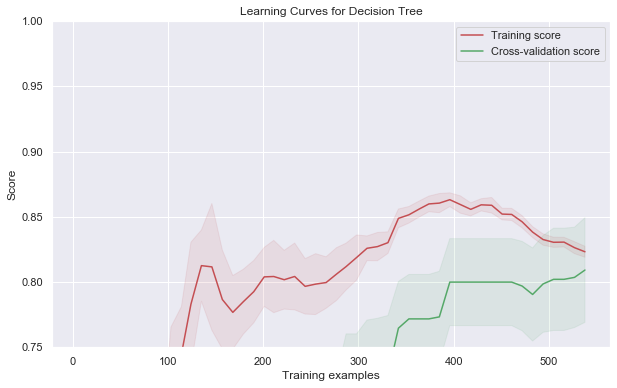

In [31]:
from sklearn.model_selection import learning_curve
# Put the following in a separate .py file and then use   %load filename.py   for importing it
#Ref: http://scikit-learn.org/stable/modules/learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(0.01, 1.0, 50)):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid("on")
    return plt


sns.set()
kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
title = 'Learning Curves for Decision Tree'
estimator = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_split=20, 
                            min_samples_leaf=5, random_state=seed)
plot_learning_curve(estimator, title, X, y, cv=kfold)
plt.ylim(0.75, 1.0)
plt.show()

## save the model to disk

In [113]:
filename = 'tense_dt_model.sav'
pickle.dump(dt, open(filename, 'wb'))

In [114]:
filename = 'tense_dt_model'
joblib.dump(dt, filename)

['tense_dt_model']

# Testing The Model With Unknown Data

In [126]:
df_t = pd.read_csv('SentenceToTenses_test.csv')

In [127]:
df_t.head()

,Unnamed: 0,text,verb1,verb2,verb3,verb4,verb5,verb6,time_exp1,time_exp2,time_exp3,time_exp4,time_exp5,tense
0,0,My breakfast will have been ready.,"verb, modal auxiliary","verb, base form","verb, past participle",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,We will have been studying for 3 days by the t...,"verb, modal auxiliary","verb, base form","verb, past participle","verb, gerund or present participle","verb, 3rd person singular present",NaN,for,days,by,time,NaN,0
2,2,She will have been working for 2 hours when we...,"verb, modal auxiliary","verb, base form","verb, past participle","verb, gerund or present participle","verb, non-3rd person singular present",NaN,for,when,NaN,NaN,NaN,0
3,3,I worked yesterday.,"verb, past tense",NaN,NaN,NaN,NaN,NaN,yesterday,NaN,NaN,NaN,NaN,7
4,4,She liked the movie.,"verb, past tense",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


In [128]:
print(df_t.groupby('tense')['Unnamed: 0'].nunique().sort_values(ascending=True).reset_index(name='count').to_string(index=False))
print('    NUMBER OF SENTENCES :        ' + str(df_t.shape[0]))

 tense  count
     0      3
     3      3
    10      3
     7      4
    11      7
    NUMBER OF SENTENCES :        20


In [129]:
df_t.drop(['Unnamed: 0'], inplace=True, axis=1)
df_t.columns

Index(['text', 'verb1', 'verb2', 'verb3', 'verb4', 'verb5', 'verb6',
       'time_exp1', 'time_exp2', 'time_exp3', 'time_exp4', 'time_exp5',
       'tense'],
      dtype='object')

In [130]:
df_t['tense'].unique()

array([ 0,  7,  3, 10, 11])

In [131]:
df_columns = df.columns.tolist()
columnsForDummies = df_columns[1:]
df_td = pd.get_dummies(df_t, drop_first=True, columns=columnsForDummies)
df_td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 20 columns):
text                                           20 non-null object
verb1_verb, modal auxiliary                    20 non-null uint8
verb1_verb, non-3rd person singular present    20 non-null uint8
verb1_verb, past tense                         20 non-null uint8
verb2_verb, gerund or present participle       20 non-null uint8
verb3_verb, past participle                    20 non-null uint8
verb5_verb, non-3rd person singular present    20 non-null uint8
time_exp1_for                                  20 non-null uint8
time_exp1_last                                 20 non-null uint8
time_exp1_right                                20 non-null uint8
time_exp1_tomorrow                             20 non-null uint8
time_exp1_yesterday                            20 non-null uint8
time_exp2_days                                 20 non-null uint8
time_exp2_now                                  20 n

In [132]:
for col in dfd.columns.tolist():
    if col not in df_td.columns:
        df_td[col] = 0

for d_col in df_td.columns:
    if d_col not in dfd.columns.tolist():
        df_td = df_td.drop([d_col], axis=1)
        
df_td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 167 entries, text to time_exp5_years
dtypes: int64(151), object(1), uint8(15)
memory usage: 24.1+ KB


In [133]:
df_td = df_td.reindex(dfd.columns, axis=1)
df_td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 167 entries, text to time_exp5_years
dtypes: int64(151), object(1), uint8(15)
memory usage: 24.1+ KB


In [134]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Columns: 167 entries, text to time_exp5_years
dtypes: object(2), uint8(165)
memory usage: 107.0+ KB


In [135]:
y = np.array(df_t['tense'])
X = np.array(df_td.drop(['text','tense'], axis=1))
print('X and y:', X.shape, y.shape)

X and y: (20, 165) (20,)


In [136]:
dt.score(X,y)

0.9

In [137]:
dt.predict(X)

array([ 0,  0,  0,  7,  7,  7,  7,  3,  3,  3, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11])

## Predictions

In [50]:
sentence_adder('My breakfast will have been ready.', 'NaN', 'SentenceToTenses_test.csv', 
               num_col=True, print_it=True)

TEXT       POS      TAG     Tag Explained                                Is Alpha  Is Stop  Num     
--------------------------------------------------------------------------------------------------
My         DET      PRP$    pronoun, possessive                          True      True     False   
breakfast  NOUN     NN      noun, singular or mass                       True      False    False   
will       VERB     MD      verb, modal auxiliary                        True      True     False   
have       VERB     VB      verb, base form                              True      True     False   
been       VERB     VBN     verb, past participle                        True      True     False   
ready      ADJ      JJ      adjective                                    True      False    False   
.          PUNCT    .       punctuation mark, sentence closer            False     False    False   
---------------------------------------------------------------------------------------------

,text,verb1,verb2,verb3,verb4,verb5,verb6,time_exp1,time_exp2,time_exp3,time_exp4,time_exp5,tense
23,My breakfast will have been ready.,"verb, modal auxiliary","verb, base form","verb, past participle",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
def tense_predictorH(sentence_df, model_df, model_df_d, model, encoder=None):
    
    
    if 'Unnamed: 0' in sentence_df.columns:
        sentence_df.drop(['Unnamed: 0'], inplace=True, axis=1)


    df_columns = model_df.columns.tolist()
    columnsForDummies = df_columns[1:]
    df_td = pd.get_dummies(sentence_df, drop_first=False, columns=columnsForDummies)

    for col in model_df_d.columns.tolist():
        if col not in df_td.columns:
            df_td[col] = 0

    for d_col in df_td.columns:
        if d_col not in model_df_d.columns.tolist():
            df_td = df_td.drop([d_col], axis=1)

    df_td = df_td.reindex(model_df_d.columns, axis=1)
    
    df_td.to_csv('sen_test.csv')

    X = np.array(df_td.drop(['text', 'tense'], axis=1))

    if encoder is None:
        prediction = model.predict(X)
    else:
        prediction = encoder.inverse_transform(model.predict(X))
    
    return prediction


In [54]:
sen_df = sentence_parser('I was home last night.')
sen_df

TEXT       POS      TAG     Tag Explained                                Is Alpha  Is Stop  Num     
--------------------------------------------------------------------------------------------------
I          PRON     PRP     pronoun, personal                            True      True     False   
was        VERB     VBD     verb, past tense                             True      True     False   
home       ADV      RB      adverb                                       True      False    False   
last       ADJ      JJ      adjective                                    True      True     False   
night      NOUN     NN      noun, singular or mass                       True      False    False   
.          PUNCT    .       punctuation mark, sentence closer            False     False    False   
--------------------------------------------------------------------------------------------------




,text,verb1,verb2,verb3,verb4,verb5,verb6,time_exp1,time_exp2,time_exp3,time_exp4,time_exp5,tense
0,I was home last night.,"verb, past tense",NaN,NaN,NaN,NaN,NaN,last,night,NaN,NaN,NaN,


In [55]:
tense_predictorH(sen_df, df, dfd, dt, label_encoder)

array(['past simple'], dtype=object)

In [101]:
pd.set_option('display.max_columns', 500)